In [1]:
from langchain_core.tools import tool
from langchain_community.utilities import SQLDatabase
from dotenv import load_dotenv
import os

from ibm_watsonx_ai import APIClient
from langchain_ibm import ChatWatsonx

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage

from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import Annotated
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver


from sqlalchemy import create_engine, MetaData, ForeignKey, text, insert, URL
from sqlalchemy import text
import pandas as pd
from langchain_core.prompts import PromptTemplate

from langchain_ollama import ChatOllama

In [2]:
load_dotenv()
url = os.getenv("URL")
apikey = os.getenv("APIKEY")
project_id = os.getenv("project_id")

In [3]:
parameters = {
    "frequency_penalty": 0,
    "max_tokens": 3000,
    "presence_penalty": 0,
    "temperature": 0,
    "top_p": 1
}

def create_chat_model(model_id):
    return ChatWatsonx(
    model_id=model_id,
    url=url,
    apikey=apikey,
    project_id=project_id,
    params=parameters,
)

model_id = "ibm/granite-3-8b-instruct"
#llm = create_chat_model(model_id)



llm = ChatOllama(
    model="granite3.2:8b-instruct-fp16",
    frequency_penalty= 0,
    max_tokens= 1000,
    presence_penalty= 0,
    temperature= 0,
    top_p= 1
)


#llm.invoke("what is the capital of Iran")

In [5]:
sqlite_engine = create_engine("sqlite:///Chinook_Sqlite.sqlite",  echo=False)
sqlite_engine.connect()
metadata_obj = MetaData()

db = SQLDatabase(sqlite_engine)
#pd.read_sql(text('SELECT * FROM Album'), sqlite_engine.connect())

In [6]:
query_prompt_template = PromptTemplate.from_template('''   
Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}
''')
query_prompt_template.pretty_print()

   
Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}



In [7]:
from typing import Annotated



class QueryOutput(TypedDict):
    """ Generated SQL query """
    query: Annotated [str, ..., "syntactically correct and valid sql query"]  # ... means there is no instruction

QueryOutput.__annotations__

{'query': typing.Annotated[str, Ellipsis, 'syntactically correct and valid sql query']}

In [8]:

class State(TypedDict):
    question: str
    query: str
    results: str
    answer: str

def write_query (state:State):
    '''
    Generate Sqlite query to fetch information 
    '''
    prompt = query_prompt_template.invoke({
        "dialect":db.dialect,
        "top_k": 5,
        "table_info" : db.get_table_info(),
        "input" : state ['question']
    })

    #return prompt
    #https://github.com/ollama/ollama/issues/8562
    structured_llm = llm.with_structured_output(QueryOutput , method  = 'json_schema' )
    results = structured_llm.invoke(prompt)

    return {"query": results["query"]}
write_query({"question":"list all albums"})

{'query': 'SELECT AlbumId, Name FROM Track GROUP BY AlbumId, Name'}

In [9]:
db.dialect

'sqlite'

In [10]:
llm.with_structured_output(QueryOutput)

RunnableBinding(bound=ChatOllama(model='granite3.2:8b-instruct-fp16', temperature=0.0, top_p=1.0), kwargs={'tools': [{'type': 'function', 'function': {'name': 'QueryOutput', 'description': 'Generated SQL query ', 'parameters': {'type': 'object', 'properties': {'query': {'description': 'syntactically correct and valid sql query', 'type': 'string'}}, 'required': ['query']}}}], 'structured_output_format': {'kwargs': {'method': 'function_calling'}, 'schema': {'type': 'function', 'function': {'name': 'QueryOutput', 'description': 'Generated SQL query ', 'parameters': {'type': 'object', 'properties': {'query': {'description': 'syntactically correct and valid sql query', 'type': 'string'}}, 'required': ['query']}}}}}, config={}, config_factories=[])
| JsonOutputKeyToolsParser(first_tool_only=True, key_name='QueryOutput')

In [11]:
from langchain_community.tools import QuerySQLDatabaseTool   #.sql_database.tool

def execute_query (state:State):
    "execute sql query and reurn the result"

    query = state['query']
    execute_query_tool = QuerySQLDatabaseTool(db=db)

    return {"results": execute_query_tool.invoke({"query":query})}

execute_query ({"query":'SELECT Title FROM Album LIMIT 5'})


{'results': "[('For Those About To Rock We Salute You',), ('Balls to the Wall',), ('Restless and Wild',), ('Let There Be Rock',), ('Big Ones',)]"}

In [12]:
#question = "list all tables in the databse"
question = "show me the higher Total sale valued item"

query = write_query({"question":question})
query

{'query': 'SELECT InvoiceLineId, InvoiceId, TrackId, UnitPrice, Quantity FROM InvoiceLine ORDER BY (UnitPrice * Quantity) DESC LIMIT 1'}

In [13]:
def generate_answer(state:State):
    print(state)
    '''generate answer using retrieved information as the context''' 
    prompt = (
        '''given the following user question, corresponding sql query, \
            and sql results, answer question,. \n\n''' 
            f'question: {state["question"]}\n'
            f'sql query:{state["query"]}\n'
            f"sql results: {state['results']}"
    )
    response = llm.invoke(prompt)
    return {"answer":response.content}

In [14]:
results = execute_query(query)
results

{'results': '[(468, 87, 2820, 1.99, 1)]'}

In [15]:
state = {"question":question, **query, **results}
state

{'question': 'show me the higher Total sale valued item',
 'query': 'SELECT InvoiceLineId, InvoiceId, TrackId, UnitPrice, Quantity FROM InvoiceLine ORDER BY (UnitPrice * Quantity) DESC LIMIT 1',
 'results': '[(468, 87, 2820, 1.99, 1)]'}

In [16]:
generate_answer(state)

{'question': 'show me the higher Total sale valued item', 'query': 'SELECT InvoiceLineId, InvoiceId, TrackId, UnitPrice, Quantity FROM InvoiceLine ORDER BY (UnitPrice * Quantity) DESC LIMIT 1', 'results': '[(468, 87, 2820, 1.99, 1)]'}


{'answer': 'The item with the highest total sale value is Track ID 2820, which was sold at a unit price of $1.99 and a quantity of 1 in Invoice ID 87 and InvoiceLine ID 468. The total sale value for this item is $1.99.'}

## Graph

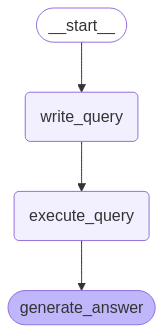

In [17]:
graph_builder = StateGraph(State)
graph_builder.add_node("write_query",write_query)
graph_builder.add_node("execute_query",execute_query)
graph_builder.add_node("generate_answer",generate_answer)
graph_builder.add_edge(START, "write_query")
graph_builder.add_edge("write_query","execute_query")
graph_builder.add_edge("execute_query","generate_answer")

graph = graph_builder.compile()
graph

In [18]:
query = P={'question':"hello"}
for step in graph.stream(query, stream_mode = "updates"):
    print(step)

{'write_query': {'query': 'hello'}}
{'execute_query': {'results': 'Error: (sqlite3.OperationalError) near "hello": syntax error\n[SQL: hello]\n(Background on this error at: https://sqlalche.me/e/20/e3q8)'}}
{'question': 'hello', 'query': 'hello', 'results': 'Error: (sqlite3.OperationalError) near "hello": syntax error\n[SQL: hello]\n(Background on this error at: https://sqlalche.me/e/20/e3q8)'}
{'generate_answer': {'answer': 'The SQL query "hello" is not a valid command in SQLite or most other SQL dialects. It seems like the user is simply greeting, which doesn\'t translate into a database operation. Therefore, an error occurred due to syntax issues. There\'s no data to return as it\'s not a proper query.'}}


# agent

In [61]:
from langchain_core.prompts import ChatPromptTemplate

In [62]:
prompt = ChatPromptTemplate.from_template('''You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables.''')

prompt

ChatPromptTemplate(input_variables=['dialect', 'top_k'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['dialect', 'top_k'], input_types={}, partial_variables={}, template='You are an agent designed to interact with a SQL database.\nGiven an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.\nUnless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.\nYou can order the results by a relevant column to return the most interesting examples in the database.\nNever query for all the columns from a specific table, only ask for the relevant columns given the question.\nYou have access to tools for interacting with the database.\nOnly use the below tools. Only use the information returned by the below tools to construct your final answer.\nYou MUST double check your query before 

In [63]:
prompt.messages[0].pretty_print()

================================ Human Message =================================

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to th

In [90]:
system_prompt = prompt.invoke({'dialect':db.dialect, 'top_k':5})
system_prompt = prompt.format(dialect = db.dialect, top_k = 5)

In [107]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

llm = ChatOllama(
    model="granite3.2:8b-instruct-fp16",
    frequency_penalty= 0,
    max_tokens= 2000,
    presence_penalty= 0,
    temperature= 0,
    top_p= 1
)



toolkit = SQLDatabaseToolkit(db= db, llm = llm)

toolkit.get_context()

{'table_info': '\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from Artist table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/\n\n\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60) NOT NULL, \n\t"Supp

In [108]:
toolkit.get_context()['table_info']

'\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from Artist table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/\n\n\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60) NOT NULL, \n\t"SupportRepId" INTEG

In [109]:
tools  = toolkit.get_tools()
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001C335745C70>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001C335745C70>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001C335745C70>),
 QuerySQLCheckerTool(description='Use this tool to 

In [110]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage



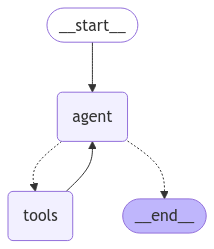

In [111]:
agent_executor = create_react_agent(llm, tools, state_modifier = system_prompt)

agent_executor

In [113]:
question = "Who are the top 3 best selling artists?"
#question = "which country's customers have made the most purchases?"
query = {"messages":[HumanMessage(question)]}

for step in agent_executor.stream(query, stream_mode = "updates"):
    print(step)
    #step['messages'][-1].pretty_print()

{'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'granite3.2:8b-instruct-fp16', 'created_at': '2025-03-10T18:05:42.8595025Z', 'done': True, 'done_reason': 'stop', 'total_duration': 22346702000, 'load_duration': 11431400, 'prompt_eval_count': 671, 'prompt_eval_duration': 489000000, 'eval_count': 284, 'eval_duration': 21840000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-420cc0b0-f1bd-49eb-ac43-aefdcf020d04-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'c209cef3-a594-479c-804b-93134faddc66', 'type': 'tool_call'}, {'name': 'sql_db_schema', 'args': {'table_names': 'sales'}, 'id': 'c7e8403d-6ba4-4cc7-8960-529e6aeb8acb', 'type': 'tool_call'}, {'name': 'sql_db_query_checker', 'args': {'query': 'SELECT artist, SUM(quantity_sold) as total_sold FROM sales GROUP BY artist ORDER BY total_sold DESC LIMIT 3'}, 'id': '92c310da-a56d-415b-b387-16ce77a2f08d', 'type': 'tool_call'}, {'name': '

In [98]:
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001C335745C70>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001C335745C70>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001C335745C70>),
 QuerySQLCheckerTool(description='Use this tool to 

In [115]:
example_query = "show me some rows from Album tables"

events = agent_executor.stream(
    {"messages": [("user", example_query)]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()



================================ Human Message =================================

show me some rows from Album tables
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (3cdeed34-9d07-4dbc-b0fc-040b2bfb15f4)
 Call ID: 3cdeed34-9d07-4dbc-b0fc-040b2bfb15f4
  Args:
    table_names: Album
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")
)

/*
3 rows from Album table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/
================================== Ai Message ==================================

Here are some rows from the Album table:

| AlbumId | Title                  | ArtistId |
|---------|------------------------

In [104]:
event["messages"]

[HumanMessage(content='show me the higher Total sale valued item', additional_kwargs={}, response_metadata={}, id='784c68d8-9be6-42a2-be2e-b75cc7162793'),
 AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'granite3.2:8b-instruct-fp16', 'created_at': '2025-03-10T17:58:32.9757543Z', 'done': True, 'done_reason': 'stop', 'total_duration': 10876388000, 'load_duration': 15508300, 'prompt_eval_count': 669, 'prompt_eval_duration': 426000000, 'eval_count': 137, 'eval_duration': 10426000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-7a289525-11fa-4547-9f8f-2cb392d5f381-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': '73f4ae36-de06-4160-ae7a-4f0acba3b6f7', 'type': 'tool_call'}, {'name': 'sql_db_list_tables', 'args': {}, 'id': 'cb985d36-97a0-4e6c-8737-adc5a309ac2c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 669, 'output_tokens': 137, 'total_tokens': 806}),
 ToolMessage(content='Album, Artist, Custom